# Building Makemore Part II: MLP
https://www.youtube.com/watch?v=TCH_1BHY58I

Imports

In [69]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Get Wordlist

In [70]:
words = open("names.txt", 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [71]:
len(words)

32033

Build the vocabulary of characters.

In [72]:
chars = sorted(list(set(''.join(words))))
print(chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create an string to integer `(stoi)` dictionary from the characters.

In [73]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


Create a reverse integer to string `(itos)` dictionary.

In [74]:
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the Dataset
For this model, if we have the name 'emma', we want to use the three characterse before as context to predict the next one.
So `— — E` (which will be our xs) predicts `M` (our y label), and `— E M` predicts `A`, and so on.

But of course, in order to do this, we need to turn those letters into numbers: E ⇨ 5, M ⇨ 13, etc.

And the end goal is to build a neural network where the vector `[0, 0, 5]` predicts `[13]`, and `[0, 5, 13]` predicts `[13]`, and so on.

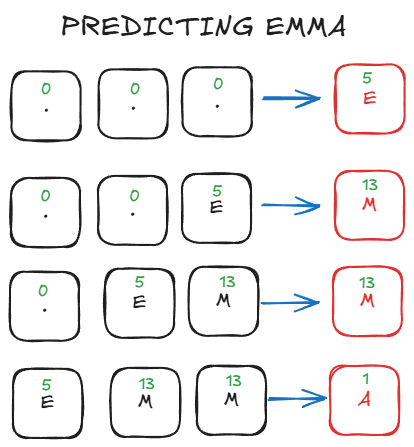


In [75]:
block_size = 3 # this is the context length
X, Y = [], [] # initializing the list

# go through all words in word list (in this case, 1 for proof of concept)
for w in words[:5]:
    context = [0] * block_size
    
    # go through all characters of each word, plust the terminator (.) character
    print('——————————')
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '⇨', itos[ix])
        context = context[1:] + [ix]



——————————
... ⇨ e
..e ⇨ m
.em ⇨ m
emm ⇨ a
mma ⇨ .
——————————
... ⇨ o
..o ⇨ l
.ol ⇨ i
oli ⇨ v
liv ⇨ i
ivi ⇨ a
via ⇨ .
——————————
... ⇨ a
..a ⇨ v
.av ⇨ a
ava ⇨ .
——————————
... ⇨ i
..i ⇨ s
.is ⇨ a
isa ⇨ b
sab ⇨ e
abe ⇨ l
bel ⇨ l
ell ⇨ a
lla ⇨ .
——————————
... ⇨ s
..s ⇨ o
.so ⇨ p
sop ⇨ h
oph ⇨ i
phi ⇨ a
hia ⇨ .


Convert X and Y into tensors which we will use in neural net.

In [76]:
X = torch.tensor(X)
Y = torch.tensor(Y)
X[:5], Y[5:]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1]]),
 tensor([15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,  1,  2,  5, 12, 12,
          1,  0, 19, 15, 16,  8,  9,  1,  0]))

X = torc


In [77]:
X.shape, X.dtype

(torch.Size([32, 3]), torch.int64)

In [78]:
Y.shape, Y.dtype

(torch.Size([32]), torch.int64)

https://youtu.be/TCH_1BHY58I?si=fWk0RD0pTRkTGKqW&t=735

## Create lookup table.

The lookup table `C` is a simple matrix where each row represents one character's embedding vector.

- **Shape**: 27 rows (one for each character) × 2 columns (embedding dimension)  
- **Purpose**: Convert character indices like `[5, 13, 13]` into embedding vectors
- **Operation**: `C[5]` literally looks up row 5 and returns that character's 2D vector
- **Example**: Character 5 (E) → `C[5]` → `tensor([-0.2733, 0.2133])` 
- **Result**: `[5, 13, 13]` becomes three 2D vectors representing E, M, M

**How the transformation works:**
- Input: `[5, 13, 13]` (three character indices)
- Index 5 → Row 5 of C → `[-0.2733, 0.2133]` (embedding for 'E')
- Index 13 → Row 13 of C → `[1.0467, 1.6703]` (embedding for 'M') 
- Index 13 → Row 13 of C → `[1.0467, 1.6703]` (same embedding for 'M' again)
- Output: 3 sets of 2 numbers each = `[[-0.2733, 0.2133], [1.0467, 1.6703], [1.0467, 1.6703]]`

It's called a "lookup table" because you're literally looking up values in a table using character indices!

In [79]:
C = torch.randn((27, 2))

In [80]:
# Display lookup table with corresponding letters
print("LOOKUP TABLE C - Character Embeddings (27×2)")
print("=" * 50)
print(f"{'Index':<5} {'Char':<4} {'Embedding Vector'}")
print("-" * 50)
for i in range(27):
    char = itos[i]
    vector = C[i]
    print(f"{i:<5} '{char}'   {vector}")

LOOKUP TABLE C - Character Embeddings (27×2)
Index Char Embedding Vector
--------------------------------------------------
0     '.'   tensor([-0.8639, -0.5018])
1     'a'   tensor([-0.6248,  0.6209])
2     'b'   tensor([ 0.3971, -1.1022])
3     'c'   tensor([-1.2698,  0.6777])
4     'd'   tensor([3.5657, 1.3049])
5     'e'   tensor([-1.6304,  0.3283])
6     'f'   tensor([ 1.1674, -1.8193])
7     'g'   tensor([-0.4246,  0.6879])
8     'h'   tensor([0.8049, 0.5898])
9     'i'   tensor([ 0.2399, -0.0438])
10    'j'   tensor([0.2548, 0.2658])
11    'k'   tensor([ 0.5573, -1.0113])
12    'l'   tensor([-1.4788, -0.9563])
13    'm'   tensor([ 0.0170, -1.9090])
14    'n'   tensor([-0.6092, -1.3129])
15    'o'   tensor([-0.1783,  1.3707])
16    'p'   tensor([-0.5485, -1.0643])
17    'q'   tensor([-1.3271,  0.7803])
18    'r'   tensor([-1.3079, -0.0563])
19    's'   tensor([-1.1526, -0.0654])
20    't'   tensor([0.5448, 1.3285])
21    'u'   tensor([ 1.9494, -0.1701])
22    'v'   tensor([ 0.411

In [81]:
F.one_hot(torch.tensor(5), num_classes=27).float()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Multiple letters at a time

## Create Embedding Vector

In [82]:
# Show how C[X] converts character indices to embedding vectors
print("C[X] - Converting all character indices to embeddings")
print("=" * 60)
print()

# Show first few examples
for i in range(min(5, len(X))):
    context = X[i]
    embeddings = C[X[i]]
    
    # Convert indices to characters for display
    chars_in_context = [itos[idx.item()] for idx in context]
    
    print(f"Example {i+1}:")
    print(f"  Input context: {context.tolist()} → {chars_in_context}")
    print(f"  Embeddings:")
    for j, (char, embed) in enumerate(zip(chars_in_context, embeddings)):
        print(f"    '{char}' (index {context[j].item()}) → {embed.tolist()}")
    print()

print(f"Full C[X] shape: {C[X].shape}")
print("This means:")
print(f"  - {C[X].shape[0]} training examples")
print(f"  - {C[X].shape[1]} characters per context") 
print(f"  - {C[X].shape[2]} embedding dimensions per character")

C[X] - Converting all character indices to embeddings

Example 1:
  Input context: [0, 0, 0] → ['.', '.', '.']
  Embeddings:
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]

Example 2:
  Input context: [0, 0, 5] → ['.', '.', 'e']
  Embeddings:
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]
    'e' (index 5) → [-1.6303727626800537, 0.32826292514801025]

Example 3:
  Input context: [0, 5, 13] → ['.', 'e', 'm']
  Embeddings:
    '.' (index 0) → [-0.8638696074485779, -0.5018460154533386]
    'e' (index 5) → [-1.6303727626800537, 0.32826292514801025]
    'm' (index 13) → [0.01699765957891941, -1.9089783430099487]

Example 4:
  Input context: [5, 13, 13] → ['e', 'm', 'm']
  Embeddings:
    'e' (index 5) → [-1.6303727626800537, 0.32826292514801025]
    'm' (index 13) → [0.0169

https://youtu.be/TCH_1BHY58I?si=Ijf7MwnMhvwYcgfx&t=1117

In [83]:
emb = C[X]
# Each of the 32 items represents one of the three character blocks.
emb[0]

tensor([[-0.8639, -0.5018],
        [-0.8639, -0.5018],
        [-0.8639, -0.5018]])

In [84]:
# character 1, character 2, character 3 [., ., .], all special characters in this instance
emb[0][0], emb[0][1], emb[0][1]

(tensor([-0.8639, -0.5018]),
 tensor([-0.8639, -0.5018]),
 tensor([-0.8639, -0.5018]))

In [85]:
# Here we are flattening the matrix
# [-0.6799, -1.1585, -0.6799, -1.1585, -0.6799, -1.1585] ⇨ . . .
# [-0.6799, -1.1585, -0.6799, -1.1585,  0.4380,  0.4858] ⇨ . . e
# [-0.6799, -1.1585,  0.4380,  0.4858,  1.1512, -0.4873] ⇨ . e m

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -1.6304,  0.3283],
        [-0.8639, -0.5018, -1.6304,  0.3283,  0.0170, -1.9090],
        [-1.6304,  0.3283,  0.0170, -1.9090,  0.0170, -1.9090],
        [ 0.0170, -1.9090,  0.0170, -1.9090, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.1783,  1.3707],
        [-0.8639, -0.5018, -0.1783,  1.3707, -1.4788, -0.9563],
        [-0.1783,  1.3707, -1.4788, -0.9563,  0.2399, -0.0438],
        [-1.4788, -0.9563,  0.2399, -0.0438,  0.4115, -1.0561],
        [ 0.2399, -0.0438,  0.4115, -1.0561,  0.2399, -0.0438],
        [ 0.4115, -1.0561,  0.2399, -0.0438, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.6248,  0.6209,  0.4115, -1.0561],
        [-0.6248,  0.6209,  0.4115, -1.0

In [86]:
# this is useful for generalizing
torch.unbind(emb, 1)

(tensor([[-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-1.6304,  0.3283],
         [ 0.0170, -1.9090],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.1783,  1.3707],
         [-1.4788, -0.9563],
         [ 0.2399, -0.0438],
         [ 0.4115, -1.0561],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.6248,  0.6209],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [ 0.2399, -0.0438],
         [-1.1526, -0.0654],
         [-0.6248,  0.6209],
         [ 0.3971, -1.1022],
         [-1.6304,  0.3283],
         [-1.4788, -0.9563],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-1.1526, -0.0654],
         [-0.1783,  1.3707],
         [-0.5485, -1.0643],
         [ 0.8049,  0.5898]]),
 tensor([[-0.8639, -0.5018],
         [-0.8639, -0.5018],
         [-1

In [87]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -1.6304,  0.3283],
        [-0.8639, -0.5018, -1.6304,  0.3283,  0.0170, -1.9090],
        [-1.6304,  0.3283,  0.0170, -1.9090,  0.0170, -1.9090],
        [ 0.0170, -1.9090,  0.0170, -1.9090, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.1783,  1.3707],
        [-0.8639, -0.5018, -0.1783,  1.3707, -1.4788, -0.9563],
        [-0.1783,  1.3707, -1.4788, -0.9563,  0.2399, -0.0438],
        [-1.4788, -0.9563,  0.2399, -0.0438,  0.4115, -1.0561],
        [ 0.2399, -0.0438,  0.4115, -1.0561,  0.2399, -0.0438],
        [ 0.4115, -1.0561,  0.2399, -0.0438, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.8639, -0.5018],
        [-0.8639, -0.5018, -0.8639, -0.5018, -0.6248,  0.6209],
        [-0.8639, -0.5018, -0.6248,  0.6209,  0.4115, -1.0561],
        [-0.6248,  0.6209,  0.4115, -1.0

A better way to do it

In [88]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [89]:
a.shape

torch.Size([18])

Can use .view to manipulate the shape of a tensor

In [90]:
a.view(2, 9), a.view(3, 6)

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17]]),
 tensor([[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17]]))

In [91]:
# storage of the data is identical
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [92]:
### they're the same, but emb.view is easier
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Let's break down this line in simple terms:
```python
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
```

**What's happening:**

1. **`emb.view(-1, 6)`** - Take our embeddings and flatten them
   - We have embeddings shape `[32, 3, 2]` (32 examples, 3 characters, 2 dimensions each)
   - Flatten to `[32, 6]` (32 examples, 6 numbers each)
   - Each row is now: `[char1_dim1, char1_dim2, char2_dim1, char2_dim2, char3_dim1, char3_dim2]`

2. **`@ W1`** - Matrix multiply with first layer weights
   - `[32, 6] @ [6, 100] = [32, 100]`
   - Each of the 32 examples gets transformed from 6 numbers to 100 numbers
   - Each of the 100 neurons looks at all 6 input numbers and produces 1 output

3. **`+ b1`** - Add the bias
   - Add bias values to each of the 100 neurons
   - Biases let neurons have different "default" activation levels

4. **`torch.tanh(...)`** - Apply activation function
   - Squishes all 100 numbers to be between -1 and 1
   - Adds non-linearity so the network can learn complex patterns
   - Without this, the network would just be linear algebra!

**Result:** `h` has shape `[32, 100]` - 32 examples, each with 100 "features" that capture different patterns from the character context.

In [93]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [94]:
# -1 is a trick to get the number of training examples
# tanh is to get the numbers between -1 and 1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [95]:
h

tensor([[-0.9665,  0.9625, -0.8656,  ..., -0.9092,  0.9997, -0.6711],
        [-0.7841, -0.5339, -0.9445,  ..., -0.5822,  1.0000, -0.4366],
        [-0.9988,  1.0000, -0.9746,  ..., -0.9998,  0.9090, -0.9477],
        ...,
        [-0.8888,  0.9125, -0.8224,  ..., -0.8781, -1.0000,  0.8829],
        [-0.9877,  0.9993, -0.4589,  ...,  0.8118,  1.0000, -0.9977],
        [-0.1434,  0.9908, -0.7253,  ..., -0.4621,  0.1663,  0.9950]])

In [96]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [97]:
logits = h @ W2 + b2

In [98]:
logits.shape

torch.Size([32, 27])

In [99]:
counts = logits.exp()

In [100]:
prob = counts / counts.sum(1, keepdims=True)

In [101]:
prob.shape

torch.Size([32, 27])

In [102]:
prob[0].sum()

tensor(1.0000)

In [103]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [104]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [105]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(21.0480)

## Model Rewritten

In [106]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [107]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
sum(p.nelement() for p in parameters)

3481

In [109]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)


## Introducing Cross Loss Entropy
To make the previous code even cleaner.
https://youtu.be/TCH_1BHY58I?si=RutfD5mvpUsiGrGl&t=1970

It's much more common in practice to use F.cross_entropy because
- it makes the backpass more efficient and 
- it doesn't create all the new tensors like counts, prob and loss and
- manuall doesn't handle extreme positive logits (100) well, but cross entropy subtraccts the largest positive logit, which has same mathematical result, without creating NaN values.

In [110]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [195]:
logits.max(1)

torch.return_types.max(
values=tensor([3.5032, 2.8479, 2.2459,  ..., 3.0370, 2.2251, 4.2419],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12,  1,  ...,  0,  1,  1]))

# Rewriting Neural Net

Imports

In [180]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Get Wordlist

In [181]:
words = open("names.txt", 'r').read().splitlines()

Build the vocabulary of characters, and the stoi and itos dictionaries.

In [182]:
# gets all unique characters in wordlist
chars = sorted(list(set(''.join(words))))

# maps characters to integers + special start/end character '.'
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

# maps integers to characrters
itos = {i: s for s, i in stoi.items()}

Building the Dataset, the entire data set this time.

In [183]:
block_size = 3 # this is the context length
X, Y = [], [] # initializing the list

# go through all words in word list (in this case, 1 for proof of concept)
for w in words:
    context = [0] * block_size
    
    # go through all characters of each word, plust the terminator (.) character
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

Parameters

In [184]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# set all parameters to require back propagation
for p in parameters:
    p.requires_grad = True

Passes

In [193]:
for _ in range(10000):

    # minibatch construct, sampling 32 random X values per pass
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward Pass
    emb = C[X[ix]] #X[ix] means only get embedding of 32 random values
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    learning_rate = 0.1 # determined optimal rate
    for p in parameters:
        p.data += -learning_rate * p.grad

print(loss.item())

2.4956421852111816


Evaluate the Entire Model

In [194]:
emb = C[X] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3310, grad_fn=<NllLossBackward0>)

## Train, Test, Split

Building the Dataset, but doing a train test split.
- Training Set 80%
- Dev Set 10%
- Test Set 10%

In [196]:
def build_dataset(words):
    block_size = 3 # this is the context length
    X, Y = [], [] # initializing the list

    # go through all words in word list (in this case, 1 for proof of concept)
    for w in words:
        context = [0] * block_size
        
        # go through all characters of each word, plust the terminator (.) character
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training set 0-80%
Xtr, Ytr = build_dataset(words[:n1]) 

# dev set 80% - 90%
Xdev, Ydev = build_dataset(words[n1:n2])

# test set 90% - 100%
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Parameters (increasing neurons this time)

In [210]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# set all parameters to require back propagation
for p in parameters:
    p.requires_grad = True

print("Number of Parameters: ", sum(p.nelement() for p in parameters))

Number of Parameters:  10281


Training the Net with the training set

In [220]:
for _ in range(30000):

    # minibatch construct, sampling 32 random X values per pass
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] #X[ix] means only get embedding of 32 random values
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    learning_rate = 0.05 # determined optimal rate
    for p in parameters:
        p.data += -learning_rate * p.grad

print(loss.item())

2.542797803878784


Evaluating result w the TRANING set

In [221]:
emb = C[Xtr] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4561, grad_fn=<NllLossBackward0>)

Evaluate the Model using the DEV set

In [222]:
emb = C[Xdev] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4538, grad_fn=<NllLossBackward0>)

### Visualizing Embedding

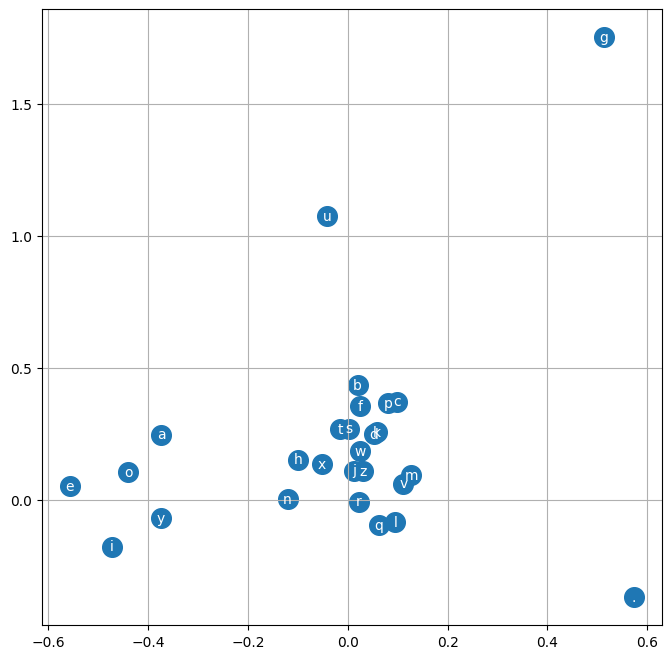

In [223]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Determining the Optimal Learning Rate Programatically

In [175]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# set all parameters to require back propagation
for p in parameters:
    p.requires_grad = True

In [176]:
learning_rate_exponent = torch.linspace(-3, 0, 1000)
learning_rate_step = 10 ** learning_rate_exponent

In [ ]:
lri = []
lossi = []

for i in range(1000):

    # minibatch construct, sampling 32 random X values per pass
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward Pass
    emb = C[X[ix]] #X[ix] means only get embedding of 32 random values
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])


    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    learning_rate = learning_rate_step[i]
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    lri.append(learning_rate_exponent[i])
    lossi.append(loss.item())


print(loss.item())

9.495015144348145


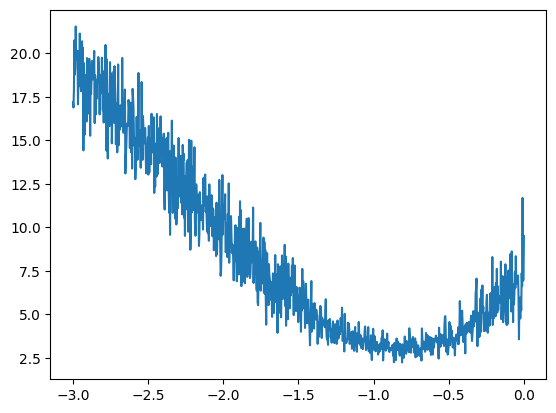

In [179]:
plt.plot(lri, lossi)

Imports

In [224]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Get Wordlist

In [225]:
words = open("names.txt", 'r').read().splitlines()

Build the vocabulary of characters, and the stoi and itos dictionaries.

In [226]:
# gets all unique characters in wordlist
chars = sorted(list(set(''.join(words))))

# maps characters to integers + special start/end character '.'
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

# maps integers to characrters
itos = {i: s for s, i in stoi.items()}

Parameters

In [ ]:
def build_dataset(words):
    block_size = 3 # this is the context length
    X, Y = [], [] # initializing the list

    # go through all words in word list (in this case, 1 for proof of concept)
    for w in words:
        context = [0] * block_size
        
        # go through all characters of each word, plust the terminator (.) character
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training set 0-80%
Xtr, Ytr = build_dataset(words[:n1]) 

# dev set 80% - 90%
Xdev, Ydev = build_dataset(words[n1:n2])

# test set 90% - 100%
Xte, Yte = build_dataset(words[n2:])

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # turning every letter into a two dimensional num
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# set all parameters to require back propagation
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(30000):

    # minibatch construct, sampling 32 random X values per pass
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] #X[ix] means only get embedding of 32 random values
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    learning_rate = 0.05 # determined optimal rate
    for p in parameters:
        p.data += -learning_rate * p.grad

print(loss.item())

Evaluating result w the TRANING set

In [ ]:
emb = C[Xtr] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4561, grad_fn=<NllLossBackward0>)

Evaluating wth DEV set

In [ ]:
emb = C[Xdev] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4538, grad_fn=<NllLossBackward0>)

# New Model with Higher Dimensional Embeddings

Imports

In [246]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Get Wordlist

In [247]:
words = open("names.txt", 'r').read().splitlines()

Build the vocabulary of characters, and the stoi and itos dictionaries.

In [248]:
# gets all unique characters in wordlist
chars = sorted(list(set(''.join(words))))

# maps characters to integers + special start/end character '.'
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

# maps integers to characrters
itos = {i: s for s, i in stoi.items()}

Parameters

In [249]:
def build_dataset(words):
    block_size = 3 # this is the context length
    X, Y = [], [] # initializing the list

    # go through all words in word list (in this case, 1 for proof of concept)
    for w in words:
        context = [0] * block_size
        
        # go through all characters of each word, plust the terminator (.) character
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training set 0-80%
Xtr, Ytr = build_dataset(words[:n1]) 

# dev set 80% - 90%
Xdev, Ydev = build_dataset(words[n1:n2])

# test set 90% - 100%
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [250]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# set all parameters to require back propagation
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [251]:
lri = []
lossi = []
stepi = []

In [258]:
for i in range(200000):

    # minibatch construct, sampling 32 random X values per pass
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] #X[ix] means only get embedding of 32 random values
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    learning_rate = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

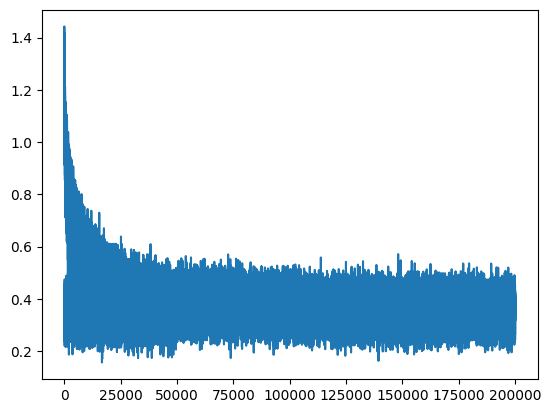

In [259]:
plt.plot(stepi, lossi)

Evalueate with training set

In [260]:
emb = C[Xtr] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2672, grad_fn=<NllLossBackward0>)

Evaluate the Model using the DEV set

In [261]:
emb = C[Xdev] #X[ix] means only get embedding of 32 random values
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2891, grad_fn=<NllLossBackward0>)

# Sampling from the Model

In [267]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khirmiri.
thty.
halaysa.
jazonel.
dreyah.
jareei.
ner.
kistcieiha.
kaleigh.
ham.
jory.
quijahsrojlmi.
jad.
qui.
jeron.
jarynix.
kaek.
duray.
edde.
